# Classification of Land Cover Using Cartographic Data

This data set is a collection of observations of forest type (Spruce/Fir, Aspen, Lodgepole Pine, etc) in four wilderness areas in Colorado. The areas are west of Fort Collins near Rocky Mountain National Park, and were chosen because they have had minimal human disturbance. The data set includes 581,012 examples (each one a 30m by 30m square plot of forest) and 54 features describing physical attributes of those plots. Ten of these features are quantitative measurements like elevation, slope and aspect, and the remaining 44 come from two classification features (wilderness area and soil type) which have been one hot encoded ahead of time by the data set creators.

A full description of the data set can be found here: https://archive.ics.uci.edu/ml/datasets/covertype. 

The data set was originally used in 1998 to compare a linear model and a neural network. With those models, they were able to achieve 58% and 70% accuracy on a test set, respectively. Twenty years later, we should be able to better and get there significantly faster. In this analysis, we won't look at neural networks specifically, but instead will model with Logistic Regression, Naive Bayes, K-Nearest Neighbors, Support Vector Machine, Decision Tree, Random Forest, and Gradient Boosting. Our primary tools will be numpy and pandas for data handling, matplotlib and seaborn for visualization, scikit-learn for modeling and analysis, and of course this Jupyter notebook for presentation.

The original owners of the data set are:

		Remote Sensing and GIS Program
		Department of Forest Sciences
		College of Natural Resources
		Colorado State University
		Fort Collins, CO  80523

The fact that they've made this data set publically available is greatly appreciated.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')

In [2]:
# Using the documentation, let's name our columns appropriately. We have 10 quantitative, numeric features,
# followed by 4 qualitative binary features for wilderness area, 40 qualitative binary features for soil type,
# and finally our outcome variable, 'Cover', which is an integer 1-7.

soil_types = ['Soil_Type_%.2d' %x for x in range(1, 41)]

col_names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
             'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
             'Horizontal_Distance_To_Fire_Points', 'Wild_Area_1', 'Wild_Area_2', 'Wild_Area_3', 'Wild_Area_4']

col_names = col_names + soil_types + ['Cover']

In [3]:
# Load in the data.

raw_data = pd.read_csv('covtype.data', names=col_names)
raw_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## Exploring the Data

Let's take a look at what we've got here. We already know what the columns mean from the documentation. The numeric features are self-explanitory with their column names. The 4 'Wild_Area' columns correspond to the following:

1. Rawah Wilderness Area
2. Neota Wilderness Area
3. Comanche Peak Wilderness Area
4. Cache la Poudre Wilderness Area

Similarly, the 40 'Soil_Type' features correspond to 40 specific soil types. Here are the first five:

1. Cathedral family - Rock outcrop complex, extremely stony.
2. Vanet - Ratake families complex, very stony.
3. Haploborolis - Rock outcrop complex, rubbly.
4. Ratake family - Rock outcrop complex, rubbly.
5. Vanet family - Rock outcrop complex complex, rubbly.

Luckily we don't need to know anything about soil to create our models. Each record should correspond to a single 'Wild_Area' and a single 'Soil_Type'. 

Our seven outcome 'Cover' types are (by corresponding integer):

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

Let's dig a little bit deeper into the numeric features in particular.

In [4]:
# Do we have any missing data? 

raw_data.isnull().sum().sum()

0

The data is nice and clean! Many thanks to the creators of this data set.

### Distributions

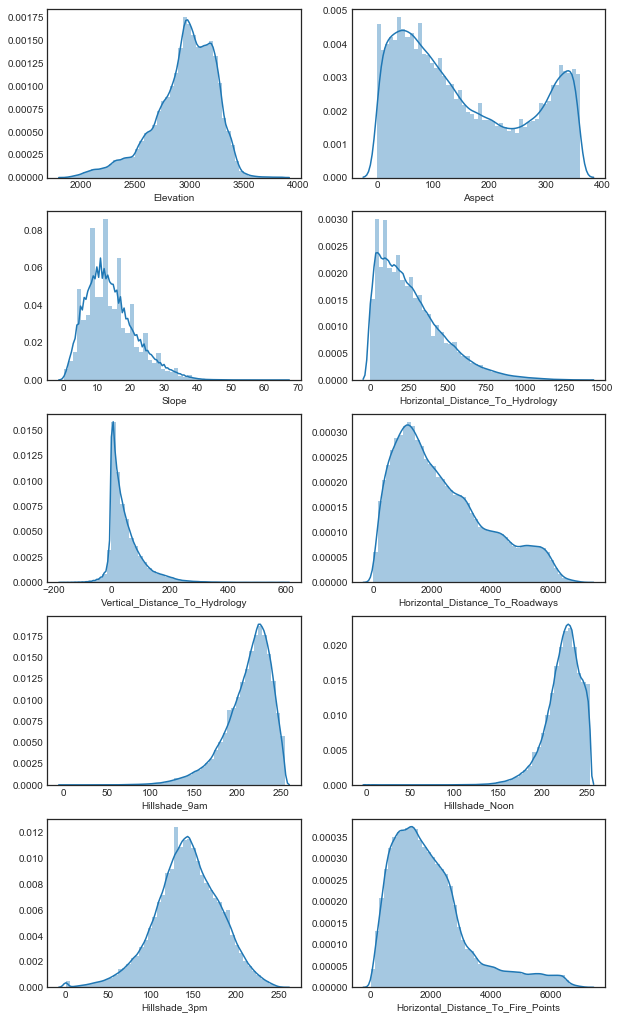

In [5]:
# Let's look at the distributions of our numeric variables.

g = plt.figure(figsize=(10,18))
i = 1
for col in raw_data.columns[:10]:
    plt.subplot(5, 2, i)
    sns.distplot(raw_data[col])
    i+=1

A few interesting things here: It appears that Slope, and to a lesser extent, Aspect are clumped around common values. Most likely they rounded Slope to the nearest 5 degrees and Aspect to the nearest 45 degrees during measurement. Other than that, this data is quite clean. Most of the data points are between 2500m and 3500m elevation, which is reasonable for Colorado wilderness. 

There aren't any outliers to speak of, and the features are all fairly smooth. Aspect has an interesting quality, which is that it actually wraps around -- 360 degrees is the same as 0 degrees. We could potentially deal with this by transforming the data by taking the cosine.

In [6]:
# Value counts for each of the binary features.

print(raw_data.loc[:, 'Wild_Area_1':'Wild_Area_4'].sum())
print(raw_data.loc[:, 'Soil_Type_01':'Soil_Type_40'].sum())

Wild_Area_1    260796
Wild_Area_2     29884
Wild_Area_3    253364
Wild_Area_4     36968
dtype: int64
Soil_Type_01      3031
Soil_Type_02      7525
Soil_Type_03      4823
Soil_Type_04     12396
Soil_Type_05      1597
Soil_Type_06      6575
Soil_Type_07       105
Soil_Type_08       179
Soil_Type_09      1147
Soil_Type_10     32634
Soil_Type_11     12410
Soil_Type_12     29971
Soil_Type_13     17431
Soil_Type_14       599
Soil_Type_15         3
Soil_Type_16      2845
Soil_Type_17      3422
Soil_Type_18      1899
Soil_Type_19      4021
Soil_Type_20      9259
Soil_Type_21       838
Soil_Type_22     33373
Soil_Type_23     57752
Soil_Type_24     21278
Soil_Type_25       474
Soil_Type_26      2589
Soil_Type_27      1086
Soil_Type_28       946
Soil_Type_29    115247
Soil_Type_30     30170
Soil_Type_31     25666
Soil_Type_32     52519
Soil_Type_33     45154
Soil_Type_34      1611
Soil_Type_35      1891
Soil_Type_36       119
Soil_Type_37       298
Soil_Type_38     15573
Soil_Type_39     13806
So

Most of our data come from the second and fourth Wilderness Area. There are several rare soil types (< 500 examples), and a few with more than 50,000 examples. The rarity of certain soil samples means that we will miss some entirely in either our training set, cross validation, or our test set. That shouldn't be too big a deal, although it may mean with misclassify a handful of examples if those soil types are highly predictive.

And finally, let's look at our outcome variable, 'Cover'.

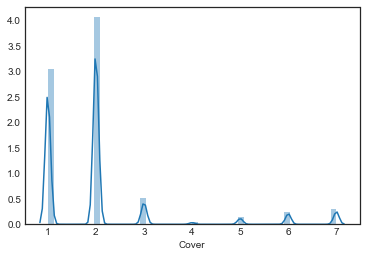

1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: Cover, dtype: int64


In [7]:
sns.distplot(raw_data.Cover)
plt.show()
print(raw_data.Cover.value_counts().sort_index())

We're dealing with a class imbalance here, so we'll want to resample the rare classes when we train our model. This also means that accuracy alone will be insufficient for judging the quality of our model. We'll need to look at the confusion matrix, precision, and recall as well. And we'll have to be sure to get some of each cover type in our test set!

### Correlations

Finally, let's look at the correlations between some of the numeric data.

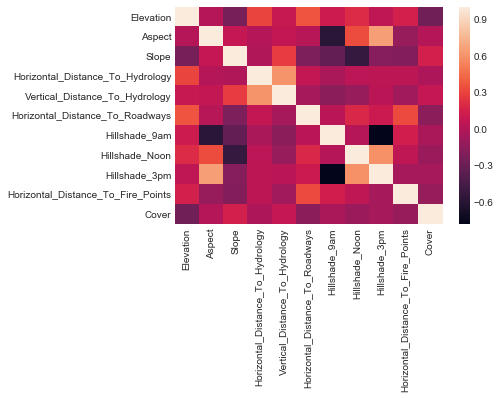

In [8]:
# Correlation matrix with all our numeric data plus 'Cover'.
# We don't really expect any correlation with 'Cover' because it is categorical.

corr_cols = raw_data.columns[:10].tolist() + ['Cover']
corr_mat = raw_data.loc[:, corr_cols].corr()
sns.heatmap(corr_mat)
plt.show()

This looks good -- there are a few places with high correlation (Verticle and Horizontal distance to water, Aspect/Slope and Hillshade), but for the most part these variables are all fairly independent. That should allow us to extract the most possible information for our models.

## Preparing the Data for Processing

Let's go ahead and create a feature for the cosine of the Aspect. Our 'Soil_Type' and 'Wild_Area' are already one-hot encoded, so nothing to do there. We'll need to separate our train/test data and resample the rare classes in the training data.

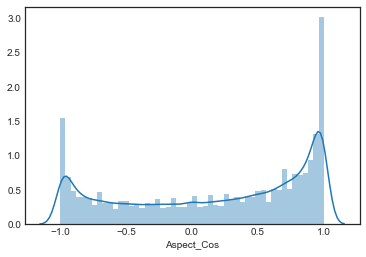

In [9]:
# Create a new column for the cosine of the Aspect.

raw_data['Aspect_Cos'] = np.cos(np.radians(raw_data.Aspect))
sns.distplot(raw_data.Aspect_Cos)
plt.show()

Taking the cosine clumps the data at the extremes as part of the transformation -- this isn't ideal, but let's leave it in along with unaltered Aspect and see how it goes.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

### Split the Data

We'll use a test size of 30% the entire set -- this should preserve each of the seven classes in both the training and test sets, but we'll double check anyway.

In [11]:
# Split the data frame first.

data_train, data_test = train_test_split(raw_data, test_size=0.3)

Let's see if we've gotten all our classes in the test set.

In [12]:
# Show the value counts for each output class.

data_test.Cover.value_counts().sort_index()

1    63374
2    85010
3    10769
4      807
5     2885
6     5236
7     6223
Name: Cover, dtype: int64

Great -- it looks like we do have enough of each so that random sample will pretty much always grab every cover type. 

### Resampling

On to resampling the training set. Let's resample all but the most frequent class up to the size of the most frequent class (which is 'Cover' = 2, if you're keeping track). This will increase the size of our training set by about 3-4 times.

In [13]:
data_train.Cover.value_counts().sort_index()

1    148466
2    198291
3     24985
4      1940
5      6608
6     12131
7     14287
Name: Cover, dtype: int64

In [14]:
# First, separate out the different classes.

data_train_1 = data_train[data_train.Cover==1]
data_train_2 = data_train[data_train.Cover==2]
data_train_3 = data_train[data_train.Cover==3]
data_train_4 = data_train[data_train.Cover==4]
data_train_5 = data_train[data_train.Cover==5]
data_train_6 = data_train[data_train.Cover==6]
data_train_7 = data_train[data_train.Cover==7]

# Resample all to the length of data_train_2.

data_train_1 = resample(data_train_1, n_samples=len(data_train_2))
data_train_3 = resample(data_train_3, n_samples=len(data_train_2))
data_train_4 = resample(data_train_4, n_samples=len(data_train_2))
data_train_5 = resample(data_train_5, n_samples=len(data_train_2))
data_train_6 = resample(data_train_6, n_samples=len(data_train_2))
data_train_7 = resample(data_train_7, n_samples=len(data_train_2))

# And recombine.

data_train = pd.concat([data_train_1, data_train_2, data_train_3, data_train_4, data_train_5, 
                        data_train_6, data_train_7]).sample(frac=1)

print(data_train.Cover.value_counts().sort_index(), '\n\nTotal Length:', len(data_train))

1    198291
2    198291
3    198291
4    198291
5    198291
6    198291
7    198291
Name: Cover, dtype: int64 

Total Length: 1388037


In [15]:
# And finally, we'll create our X and Y arrays for processing.

X_train = data_train.loc[:, ~data_train.columns.isin(['Cover'])]
Y_train = data_train.Cover
X_test = data_test.loc[:, ~data_train.columns.isin(['Cover'])]
Y_test = data_test.Cover

print('Sanity check on array shapes:\n', X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Sanity check on array shapes:
 (1388037, 55) (1388037,) (174304, 55) (174304,)


## Feature Selection

Let's take a look at how our features behave, and see how using selected features compares to using the whole feature set. We'll try out RFE, Select K Best, feature importances from random forest, and PCA. Let's start with feature importances to get a sense of how many features we'll want to keep.

In [57]:
# Let's just get all the sklearn stuff out of the way.

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, classification_report

In [38]:
# We'll run an unmodified random forest to get feature importances. 
# This will also be a good way to see where we're starting from with regards to model accuracy.

rfc = RandomForestClassifier()
rfc.fit(X_train,Y_train)
Y_pred = rfc.predict(X_test)
print(rfc.score(X_test, Y_test))
print(confusion_matrix(Y_test, Y_pred))

0.93211286029
[[58528  4563     9     0    38    14   222]
 [ 3697 80555   298     3   212   212    33]
 [    6   181 10251    51    14   266     0]
 [    0     1   128   657     0    21     0]
 [   42   576    44     0  2215     8     0]
 [   10   223   591    25     6  4381     0]
 [  308    31     0     0     0     0  5884]]


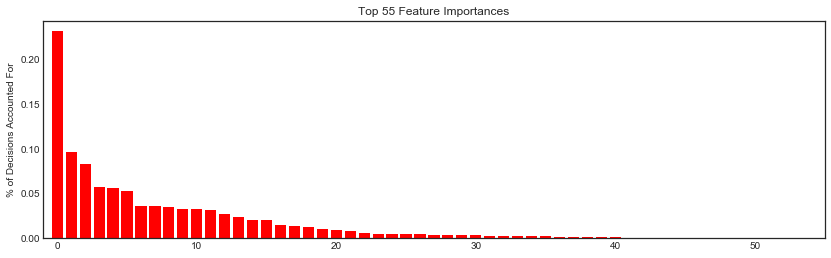

In [39]:
# Extract the top X feature importances. With only 55 features, we'll visualize all of them.

importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[:55]

# Plot the feature importances

plt.figure(figsize=(14, 4))
plt.title("Top {} Feature Importances".format(len(top_indices)))
plt.bar(range(len(top_indices)), importances[top_indices],
       color="r", align="center")
plt.xlim([-1, len(top_indices)])
plt.ylabel('% of Decisions Accounted For')
plt.show()

In [40]:
# And let's see what percentage of decisions are accounted for with the top X features.

for n_idx in range(5, 56, 5):
    print('Percentage of decisions accounted for with {} features: {}'.format(n_idx, importances[indices[:n_idx]].sum()))
print('Total Features: ' + str(len(indices)))

Percentage of decisions accounted for with 5 features: 0.5243352424693267
Percentage of decisions accounted for with 10 features: 0.7166536608947304
Percentage of decisions accounted for with 15 features: 0.8513172868550262
Percentage of decisions accounted for with 20 features: 0.9223587635918397
Percentage of decisions accounted for with 25 features: 0.954443839311077
Percentage of decisions accounted for with 30 features: 0.9754263739840581
Percentage of decisions accounted for with 35 features: 0.9885622345539569
Percentage of decisions accounted for with 40 features: 0.9960070441251646
Percentage of decisions accounted for with 45 features: 0.9989828072073453
Percentage of decisions accounted for with 50 features: 0.999853281933548
Percentage of decisions accounted for with 55 features: 1.0000000000000002
Total Features: 55


Let's see how those techniques do. Let's reduce to 25 features since we could potentially account for 95% of the decisions from the random forest. What are these features in the real world?

In [41]:
n_indices = 25
X_train.columns[indices[:n_indices]]

Index(['Elevation', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points', 'Wild_Area_4',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Hillshade_9am', 'Hillshade_3pm', 'Aspect_Cos', 'Soil_Type_10',
       'Aspect', 'Hillshade_Noon', 'Slope', 'Soil_Type_38', 'Soil_Type_39',
       'Soil_Type_03', 'Wild_Area_3', 'Wild_Area_1', 'Soil_Type_40',
       'Soil_Type_02', 'Soil_Type_04', 'Soil_Type_30', 'Soil_Type_22',
       'Soil_Type_12', 'Soil_Type_17'],
      dtype='object')

Neat -- all of our numeric features made it near the top, with only two binary features doing that well (Wild_Area_4 and Soil_Type_10). After that, a smattering of the most revealing soil types and wilderness areas.

In [42]:
# And now choosing those best features to be in our modified feature set:

X_train_rfc = X_train.loc[:, X_train.columns[indices[:n_indices]]]
X_test_rfc = X_test.loc[:, X_train.columns[indices[:n_indices]]]
print(X_train_rfc.shape, X_test_rfc.shape)

(1388037, 25) (174304, 25)


### Other Feature Selection Techniques

We'll also make training sets using RFE, Select K Best, and PCA. We'll use 25 features for all of them for consistency.

In [23]:
# Selection with RFE:

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=n_indices)
rfe.fit(X_train, Y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [43]:
# Selection with Select K Best:

skb = SelectKBest(k=n_indices)
skb.fit(X_train, Y_train)
X_train_skb = skb.transform(X_train)
X_test_skb = skb.transform(X_test)

In [44]:
# Decomposition with PCA:

pca = PCA(n_components=n_indices)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

### Feature Selection Comparison

Now let's see how they all compare! Again, we'll test them out with an unmodified random forest.

In [39]:
# Simply taking the cross validation score of each training set, using random forest.

print('Scores with all features: ')
print(cross_val_score(rfc, X_train, Y_train, cv=4))

print('Scores with feature importances: ')
print(cross_val_score(rfc, X_train_rfc, Y_train, cv=4))

print('Scores with RFE: ')
print(cross_val_score(rfc, X_train_rfe, Y_train, cv=4))

print('Scores with Select K Best: ')
print(cross_val_score(rfc, X_train_skb, Y_train, cv=4))

print('Scores with PCA: ')
print(cross_val_score(rfc, X_train_pca, Y_train, cv=4))

Scores with all features: 
[ 0.98709767  0.98714092  0.98717816  0.98697628]
Scores with feature importances: 
[ 0.98699673  0.98718707  0.98770303  0.98744636]
Scores with RFE: 
[ 0.9876283   0.98753313  0.9874925   0.98770879]
Scores with Select K Best: 
[ 0.9880378   0.9880205   0.98821348  0.98836633]
Scores with PCA: 
[ 0.98784458  0.98820795  0.98803179  0.98814138]


It actually looks like we did better with Select K Best and PCA than we did with our full feature set! This may be because overfitting was reduced. We'll train our models on the full data set, and then use these engineered feature sets to deepen the analysis. For the most part, we'll use SKB over PCA so we can preserve our column descriptions for analysis.

## Model Selection

Let's run our data through several models, tune parameters for each, see how they compare, and choose the best one(s) to move forward with. We'll take a look at Logistic Regression, K-Nearest Neighbors, Naive Bayes, SVC, Decision Tree, Random Forest, and Gradient Doosting. We'll also keep track of how long each takes to run so we don't get stuck with a behemoth. We'll save most of the analysis for the next section and just run the models here.

In [17]:
# We'll use datetime to measure our processing speed, and a couple functions to cut down on typing.

import datetime

def t_now(): return datetime.datetime.now()
def t_dif(tic): return str(t_now() - tic)

### Logistic Regression

In [41]:
# Logistic Regression - find best parameters with gridsearch and display results.

tic = t_now()

lgr_params = {'penalty':['l1', 'l2'],
              'C':[0.01, 1, 100]}
lgr_grid = GridSearchCV(LogisticRegression(), lgr_params, cv=4)
lgr_grid.fit(X_train, Y_train)
print('Best Score: ', lgr_grid.best_score_)
print('Best Parameters: ', lgr_grid.best_params_)
Y_pred_lgr = lgr_grid.predict(X_test)
print(confusion_matrix(Y_test, Y_pred_lgr))
print(classification_report(Y_test, Y_pred_lgr))

print(t_dif(tic))

Best Score:  0.677025310341
Best Parameters:  {'C': 100, 'penalty': 'l1'}
[[40693 10056    65     0  4117   586  7897]
 [19758 39979  2339    39 18584  3614   842]
 [    0    47  5972  1505   403  2784     0]
 [    0     0    46   698     0    55     0]
 [   60   419   223     0  2024   149     0]
 [    0   181  1003   527   408  3080     0]
 [  712    18    26     0    17     0  5378]]
             precision    recall  f1-score   support

          1       0.66      0.64      0.65     63414
          2       0.79      0.47      0.59     85155
          3       0.62      0.56      0.59     10711
          4       0.25      0.87      0.39       799
          5       0.08      0.70      0.14      2875
          6       0.30      0.59      0.40      5199
          7       0.38      0.87      0.53      6151

avg / total       0.69      0.56      0.60    174304

12:37:06.995245


Ran VERY slowly and didn't to very well.

### K Nearest Neighbors

In [31]:
# K Nearest Neighbors - find best parameters with gridsearch and display results.

tic = t_now()

knc_params = {'n_neighbors':[2, 4, 6, 8, 10]}
knc_grid = GridSearchCV(KNeighborsClassifier(), knc_params, cv=4)
knc_grid.fit(X_train, Y_train)
print('Best Score: ', knc_grid.best_score_)
print('Best Parameters: ', knc_grid.best_params_)
Y_pred_knc = knc_grid.predict(X_test)
print(confusion_matrix(Y_test, Y_pred_knc))
print(classification_report(Y_test, Y_pred_knc))

print(t_dif(tic))

Best Score:  0.99099375593
Best Parameters:  {'n_neighbors': 2}
[[61953  1132     2     0    44     5   238]
 [ 3380 81129   128     0   250    96    27]
 [    1   136 10358    60    22   192     0]
 [    0     1    97   673     0    36     0]
 [   35   260    23     0  2556    10     1]
 [    2   118   164    36    11  4905     0]
 [  169    33     0     0     1     0  6020]]
             precision    recall  f1-score   support

          1       0.95      0.98      0.96     63374
          2       0.98      0.95      0.97     85010
          3       0.96      0.96      0.96     10769
          4       0.88      0.83      0.85       807
          5       0.89      0.89      0.89      2885
          6       0.94      0.94      0.94      5236
          7       0.96      0.97      0.96      6223

avg / total       0.96      0.96      0.96    174304

0:42:54.411543


Very fast and accurate!

### Naive Bayes

In [70]:
# Naive Bayes - find best parameters with gridsearch and display results.

tic = t_now()

bnb_params = {'alpha':[0.01, 1],
              'binarize':[0, 5, 50]}
bnb = GridSearchCV(BernoulliNB(), bnb_params, cv=4)
bnb.fit(X_train, Y_train)
print('Best Score: ', bnb.best_score_)
print('Best Parameters: ', bnb.best_params_)

#bnb = GaussianNB()
#bnb.fit(X_train, Y_train)

Y_pred_bnb = bnb.predict(X_test)
print(confusion_matrix(Y_test, Y_pred_bnb))
print(classification_report(Y_test, Y_pred_bnb))

print(t_dif(tic))

Best Score:  0.606801547797
Best Parameters:  {'alpha': 0.01, 'binarize': 0}
[[28358 20367    43     0  7343   399  6864]
 [18282 41559  2210   129 19502  2698   630]
 [    1    40  5116  1519   738  3355     0]
 [    0     0    67   718     0    22     0]
 [  314   527   238     0  1736    70     0]
 [   74   248  1130   366   557  2861     0]
 [  384   476    22     0   294     0  5047]]
             precision    recall  f1-score   support

          1       0.60      0.45      0.51     63374
          2       0.66      0.49      0.56     85010
          3       0.58      0.48      0.52     10769
          4       0.26      0.89      0.41       807
          5       0.06      0.60      0.11      2885
          6       0.30      0.55      0.39      5236
          7       0.40      0.81      0.54      6223

avg / total       0.60      0.49      0.53    174304

0:02:38.578421


Very poor fit, luckily it did so quickly.

### SVC

After some time trying to run SVC( ) to no avail, I found this in the sklearn documentation: 

    The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.
    
We have over 1,000,000 samples, which is a clear explanation of why this model won't run. We may be able to get some results using LinearSVC, and using only a portion of the data set. This reduces it to a linear model, but standard SVC isn't feasible.

In [76]:
# SVC - find best parameters with gridsearch and display results.

tic = t_now()

svc_params = {'C':[1],
              'dual':[False],
              }
svc_grid = GridSearchCV(LinearSVC(), svc_params, cv=4)
svc_grid.fit(X_train, Y_train)
print('Best Score: ', svc_grid.best_score_)
print('Best Parameters: ', svc_grid.best_params_)
Y_pred_svc = svc_grid.predict(X_test)
print(confusion_matrix(Y_test, Y_pred_svc))
print(classification_report(Y_test, Y_pred_svc))

print(t_dif(tic))

Best Score:  0.659823189151
Best Parameters:  {'C': 1, 'dual': False}
[[39242  9908    51     0  4666   608  8899]
 [21736 36318  1977   102 19687  3929  1261]
 [    1    83  5286  1615   456  3326     2]
 [    0     0    50   712     0    45     0]
 [  124   325   209     0  2098   126     3]
 [    1   123   928   536   488  3158     2]
 [  618    25    22     0    38     0  5520]]
             precision    recall  f1-score   support

          1       0.64      0.62      0.63     63374
          2       0.78      0.43      0.55     85010
          3       0.62      0.49      0.55     10769
          4       0.24      0.88      0.38       807
          5       0.08      0.73      0.14      2885
          6       0.28      0.60      0.38      5236
          7       0.35      0.89      0.50      6223

avg / total       0.67      0.53      0.56    174304

0:33:42.834540


Did about as well as the linear model, and actually ran a lot faster than expected (still only using 50% of the data).

### Decision Tree

In [18]:
# Decision Tree Classifier - find best parameters with gridsearch and display results.

tic = t_now()

dtc_params = {'max_depth':[8, 32, None],
              'min_samples_split':[2, 8, 32],
              'max_features':['sqrt', None]}
dtc_grid = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=4)
dtc_grid.fit(X_train, Y_train)
print('Best Score: ', dtc_grid.best_score_)
print('Best Parameters: ', dtc_grid.best_params_)
Y_pred_dtc = dtc_grid.predict(X_test)
print(confusion_matrix(Y_test, Y_pred_dtc))
print(classification_report(Y_test, Y_pred_dtc))

print(t_dif(tic))

Best Score:  0.98606161075
Best Parameters:  {'max_depth': None, 'max_features': None, 'min_samples_split': 2}
[[57859  5022    12     0    64    17   400]
 [ 3392 80729   268     1   365   216    39]
 [   10   337  9823    76    28   495     0]
 [    0     2    96   671     0    38     0]
 [   67   495    40     0  2273    10     0]
 [   14   265   511    32    16  4398     0]
 [  355    48     0     0     2     0  5818]]
             precision    recall  f1-score   support

          1       0.94      0.91      0.93     63374
          2       0.93      0.95      0.94     85010
          3       0.91      0.91      0.91     10769
          4       0.86      0.83      0.85       807
          5       0.83      0.79      0.81      2885
          6       0.85      0.84      0.84      5236
          7       0.93      0.93      0.93      6223

avg / total       0.93      0.93      0.93    174304

0:24:00.710758


Quite good results and very fast to run.

### Random Forest

In [19]:
# Random Forest - find best parameters with gridsearch and display results.

tic = t_now()

rfc_params = {'n_estimators':[8, 24, 64],
              'min_samples_split':[2, 8],
              'max_features':['sqrt', None]}
rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, cv=4)
rfc_grid.fit(X_train, Y_train)
print('Best Score: ', rfc_grid.best_score_)
print('Best Parameters: ', rfc_grid.best_params_)
Y_pred_rfc = rfc_grid.predict(X_test)
print(confusion_matrix(Y_test, Y_pred_rfc))
print(classification_report(Y_test, Y_pred_rfc))

print(t_dif(tic))

Best Score:  0.992048482857
Best Parameters:  {'max_features': None, 'min_samples_split': 2, 'n_estimators': 64}
[[60218  2854     1     0    43     7   251]
 [ 1837 82479   212     1   296   149    36]
 [    4    98 10258    73    22   314     0]
 [    0     0    97   684     0    26     0]
 [   42   291    45     0  2498     9     0]
 [    3    99   300    30    12  4792     0]
 [  178    28     0     0     1     0  6016]]
             precision    recall  f1-score   support

          1       0.97      0.95      0.96     63374
          2       0.96      0.97      0.97     85010
          3       0.94      0.95      0.95     10769
          4       0.87      0.85      0.86       807
          5       0.87      0.87      0.87      2885
          6       0.90      0.92      0.91      5236
          7       0.95      0.97      0.96      6223

avg / total       0.96      0.96      0.96    174304

7:15:32.557243


Great results (although not better than KNN), but medium/slow runtime.

### Gradient Boosting

In [73]:
# Gradient Boosting - find best parameters with gridsearch and display results.

tic = t_now()

gbc_params = {'n_estimators':[100],
              'max_depth':[3]}
gbc_grid = GridSearchCV(GradientBoostingClassifier(), gbc_params, cv=4)
gbc_grid.fit(X_train.sample(frac=0.5, random_state=100), Y_train.sample(frac=0.5, random_state=100))
print('Best Score: ', gbc_grid.best_score_)
print('Best Parameters: ', gbc_grid.best_params_)
Y_pred_gbc = gbc_grid.predict(X_test)
print(confusion_matrix(Y_test, Y_pred_gbc))
print(classification_report(Y_test, Y_pred_gbc))

print(t_dif(tic))

Best Score:  0.813359307684
Best Parameters:  {'max_depth': 3, 'n_estimators': 100}
[[45779  9572    63     0  2094   286  5580]
 [17554 49913  1813    13 11830  3230   657]
 [    0     7  8107   571   290  1794     0]
 [    0     0    24   767     0    16     0]
 [    2   141    55     0  2635    52     0]
 [    0    38   811   153    92  4142     0]
 [  310     2     0     0    10     0  5901]]
             precision    recall  f1-score   support

          1       0.72      0.72      0.72     63374
          2       0.84      0.59      0.69     85010
          3       0.75      0.75      0.75     10769
          4       0.51      0.95      0.66       807
          5       0.16      0.91      0.27      2885
          6       0.44      0.79      0.56      5236
          7       0.49      0.95      0.64      6223

avg / total       0.75      0.67      0.69    174304

2:07:36.841170


Very slow to run, to the point where tuning is not feasible. This two-hour run used half the training set and only tested one parameter configuration.

## Model Results

A brief summary of our model results. The scores are taken on the test set and averaged over the 7 classes.

#### Logistic Regression:

    Ran very slowly (2+ hrs/run), did poorly. About as accurate as the linear model from the previous analysis.
    Avg Precision: 0.69
    Avg Recall: 0.56
    Avg F1 Score: 0.60

#### K Nearest Neighbors:

    Ran quickly (8 min/run), did very well. One of the best models.
    Avg Precision: 0.96
    Avg Recall: 0.96
    Avg F1 Score: 0.96
    
#### Naive Bayes:
      
    Ran very quickly (40 sec/run), but did poorly. GaussianNB did worse than BernoulliNB.
    Avg Precision: 0.60
    Avg Recall: 0.49
    Avg F1 Score: 0.53    

#### Linear SVC:

    SVC ran too slowly to be feasible. 
    Linear SVC was faster but only did as well as logistic regression (30 min/run).
    Avg Precision: 0.67
    Avg Recall: 0.53
    Avg F1 Score: 0.56
    
#### Decision Tree:

    Ran very quickly (2 min/run), did quite well.
    Avg Precision: 0.93
    Avg Recall: 0.93
    Avg F1 Score: 0.93
    
#### Random Forest: 

    Medium runtime (35 min/run), did very well. One of the best models.
    Avg Precision: 0.96
    Avg Recall: 0.96
    Avg F1 Score: 0.96
    
#### Gradient Boosting:

    Ran too slowly to be feasible. 
    With 10% of the data (8 min):           With 50% of the data (2 hours):
    Avg Precision: 0.74                     Avg Precision: 0.75
    Avg Recall: 0.67                        Avg Recall: 0.67
    Avg F1 Score: 0.69                      Avg F1 Score: 0.69

Let's look in depth at each model.

### Logistic Regression Analysis

Logistic Regression did poorly and worked slowly -- why?

Digging into the documentation, it appears that part of the issue may have been using a single-class solver algorithm on a multi-class problem. By default, linear regression uses a 'one-versus-all' technique for multi-class problems, which means running the regression seven times for each pass. It seems a better solver choice would have been 'sag' or 'saga'. Let's see how it works.

In [74]:
# Linear Regression with a multi-class solver

tic = t_now()

lgr = LogisticRegression(solver='sag')
lgr.fit(X_train, Y_train)

Y_pred_lgr = lgr.predict(X_test)

print('Confusion Matrix: \n\n', confusion_matrix(Y_test, Y_pred_lgr), '\n')
print('Classification Report: \n\n', classification_report(Y_test, Y_pred_lgr))

print(t_dif(tic))

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Confusion Matrix: 

 [[27873 11258   255    31  8130   939 14888]
 [17360 34573  3298   163 19690  6592  3334]
 [    0   438  3334  2014  1520  3462     1]
 [    0     0    56   666     7    77     1]
 [  184   510   145     2  1751   283    10]
 [    0   224   676   674   323  3337     2]
 [  353    71     9     0    60     0  5730]] 

Classification Report: 

              precision    recall  f1-score   support

          1       0.61      0.44      0.51     63374
          2       0.73      0.41      0.52     85010
          3       0.43      0.31      0.36     10769
          4       0.19      0.83      0.31       807
          5       0.06      0.61      0.10      2885
          6       0.23      0.64      0.33      5236
          7       0.24      0.92      0.38      6223

avg / total       0.62      0.44      0.49    174304

2:25:41.478254


Well, it's not any better, it's actually noticeably worse. The model coefficients didn't converge in the maximum 1,000 iterations, which wasn't an issue with the default solver. The same was true for 'sag' and 'saga'.

Looking at these results alongside those from LinearSVC( ), it appears that our linear models all top out around f1_score of 0.60. This may be the best a linear model can do -- the data itself may not be conducive to a linear fit. 

### K Nearest Neighbors Analysis

KNN did fantastic and was very fast to run. It worked best with the fewest number of neighbors (n_neighbors=2), which suggests the potential for overfitting (it did perform > 0.99 on cross validation), as well as sharp boundaries between classes. However, by doing so it was able to perform well, even on the rare classes. It did slightly better on precision than recall in the least common class (0.88 vs. 0.83), but is still on par with random forest.

Let's run KNN a couple more times with feature selection to see if we can reduce overfitting and perhaps perform a bit better on the test set. First with Select K Best, as it did well before.

In [91]:
# K Nearest Neighbors with Select K Best feature selection.

tic = t_now()

knc = KNeighborsClassifier(n_neighbors=2)
knc.fit(X_train_skb, Y_train)
Y_pred_knc = knc.predict(X_test_skb)

print('Cross Val Score: \n\n', cross_val_score(knc, X_train_skb, Y_train, cv=4))
print('\nConfusion Matrix: \n\n', confusion_matrix(Y_test, Y_pred_knc))
print('\nClassification Report: \n\n', classification_report(Y_test, Y_pred_knc))

print(t_dif(tic))

Cross Val Score: 

 [ 0.9889283   0.98866607  0.98890525  0.98885892]
Confusion Matrix: 

 [[61723  1322     1     0    42     2   284]
 [ 4108 80253   193     1   324   104    27]
 [    3   208 10202    75    21   260     0]
 [    0     1   100   672     0    34     0]
 [   39   293    27     0  2515    10     1]
 [    0   139   243    32    11  4811     0]
 [  200    45     0     0     1     0  5977]] 

Classification Report: 

              precision    recall  f1-score   support

          1       0.93      0.97      0.95     63374
          2       0.98      0.94      0.96     85010
          3       0.95      0.95      0.95     10769
          4       0.86      0.83      0.85       807
          5       0.86      0.87      0.87      2885
          6       0.92      0.92      0.92      5236
          7       0.95      0.96      0.96      6223

avg / total       0.95      0.95      0.95    174304

0:01:51.683496


The model has slightly lower cross validation scores and performs just a hair worse using Select K Best than it did with the full feature set.

Let's also add one last feature selection technique. It could save researches a lot of time if they didn't have to determine 'Soil_Type' for every plot of land we're testing. We'll create a feature set that includes everything except the 40 columns of soil data and see if it's still adequate for modeling.

In [86]:
# Grab all the columns except soil type for our new training set.

X_train_nosoil = X_train.loc[:, ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wild_Area_1', 'Wild_Area_2',
       'Wild_Area_3', 'Wild_Area_4', 'Aspect_Cos']]
X_test_nosoil = X_test.loc[:, ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wild_Area_1', 'Wild_Area_2',
       'Wild_Area_3', 'Wild_Area_4', 'Aspect_Cos']]

print(X_train_nosoil.shape, X_test_nosoil.shape)

(1388037, 15) (174304, 15)


In [90]:
# K Nearest Neighbors with "No Soil" feature selection.

tic = t_now()

knc = KNeighborsClassifier(n_neighbors=2)
knc.fit(X_train_nosoil, Y_train)
Y_pred_knc = knc.predict(X_test_nosoil)

print('Cross Val Score: \n\n', cross_val_score(knc, X_train_nosoil, Y_train, cv=4))
print('\nConfusion Matrix: \n\n', confusion_matrix(Y_test, Y_pred_knc))
print('\nClassification Report: \n\n', classification_report(Y_test, Y_pred_knc))

print(t_dif(tic))

Cross Val Score: 

 [ 0.9910291   0.99091671  0.99121354  0.99081567]
Confusion Matrix: 

 [[61955  1131     2     0    44     5   237]
 [ 3381 81130   128     0   248    96    27]
 [    1   136 10358    60    22   192     0]
 [    0     1    97   673     0    36     0]
 [   35   260    23     0  2556    10     1]
 [    2   119   162    36    10  4907     0]
 [  169    33     0     0     1     0  6020]] 

Classification Report: 

              precision    recall  f1-score   support

          1       0.95      0.98      0.96     63374
          2       0.98      0.95      0.97     85010
          3       0.96      0.96      0.96     10769
          4       0.88      0.83      0.85       807
          5       0.89      0.89      0.89      2885
          6       0.94      0.94      0.94      5236
          7       0.96      0.97      0.96      6223

avg / total       0.96      0.96      0.96    174304

0:01:14.234432


This is great news. KNN did just as well with no soil features as it did with them (we're actually still overfitting). This could potentially save a huge amount of time in data collection -- everything we've used in this analysis can be calculated from a map and a digital elevation model (DEM) using simple GIS tools. 

### Naive Bayes Analysis

Naive Bayes did the worst of our models on this data set. This makes sense, as BernoulliNB( ) is designed for boolean/binary features, not numeric ones. I ran GaussianNB( ) as well, and the results were worse. Not much to say about this one -- it's the wrong model for the job.

### SVC Analysis

First passes with SVC( ) proved impossible. After over twelve hours on a single pass, I canceled the run and decided to pursue other options. This makes sense given the notes in the documentation. Fit time complexity is more than the square of the number of examples -- with 1.3 million examples, it's not feasible (they suggest no more than a few 10,000's examples).

LinearSVC( ) with a fraction of the examples proved more fruitful, however, the results were not good. Average F1 score topped out at 0.56. These results are on par with our logistic regression (which makes sense since this model is linear), and nowhere close to our KNN, decision tree, or random forest. 

It seems that the correlation between the features and outcome class is not linear, as all the linear models did poorly. Perhaps SVC with a kernel method could do well, but at cost of greatly increased complexity. Considering the long processing time and poor performance, this is the wrong classifier for this data set.

### Decision Tree Analysis

Decision tree did well and ran quickly. The best model used a deep tree with no limit on the number of features to look at before deciding on each split.

We'll visualize the top few brances of our tree to try to get a sense of what choices are most important. Our decision tree overfit the training set (avg cv score > 0.98), so let's remove soil from the analysis since it worked well with KNN.

In [48]:
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

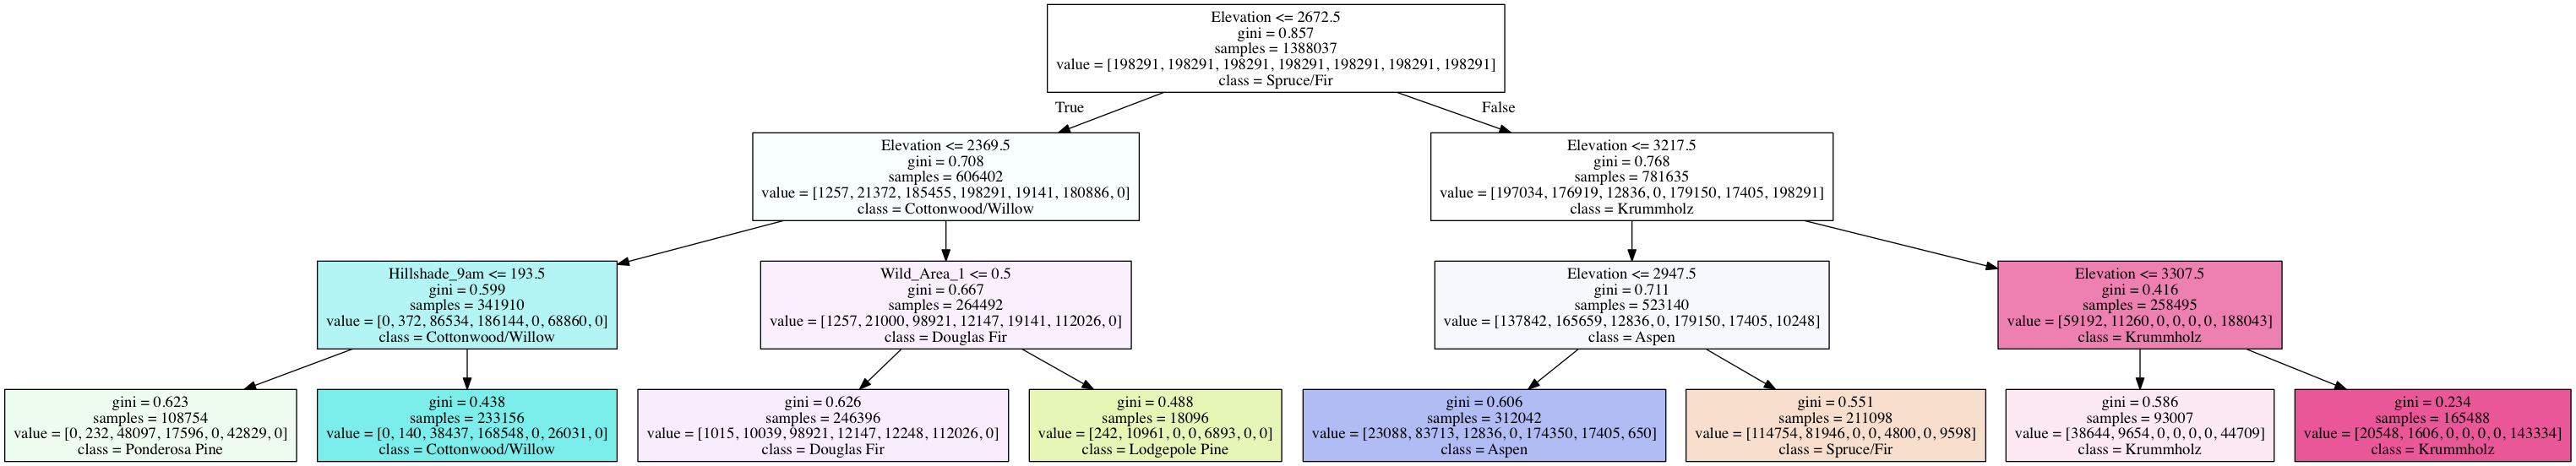

In [97]:
# Run dtc with best parameters, and visualize the tree results. 
# It isn't helpful to visualize with max_depth=None, so let's just look at a few layers
# to see the initial decisions the tree is making.

dtc = DecisionTreeClassifier(max_depth=3, max_features=None, min_samples_split=2)
dtc.fit(X_train_nosoil, Y_train)
Y_pred_dtc = dtc.predict(X_test_nosoil)

dot_data = tree.export_graphviz(
    dtc, out_file=None,
    feature_names=X_train_nosoil.columns,
    class_names=['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas Fir', 'Krummholz'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

This is very cool. Elevation is the primary defining feature, even down to the third layer of the tree. Here's what we're looking at: 

At the highest elevations (> 3200m), Krummholz is dominant. Slightly lower is Spruce/Fir (between 2950m and 3200m), followed by Aspen (between 2650m and 2950m). At lower elevations (between 2350m and 2650m), Lodgepole Pine dominates the Rawah Wilderness Area (Wild_Area=1), while Doug Fir is more common elsewhere. At the lowest elevations (< 2350m), Cottonwood/Willow is common where Hillshade_9am is high, while Ponderosa Pine is common where Hillshade_9am is low.

That's a remarkable amount of information to be able to extract from a model like this! The saturation of the colors in the final nodes correspond to how dominant each tree species is -- the lighter colored boxes have more variation. 

### Random Forest Analysis

Our random forest model performed great -- F1 score of 0.96 on the test set. It appears to have overfit the training data, even using cross validation (average score=0.99). Even so, the precision and recall are remarkable (0.96), considering the best values achieved by the original neural network analysis (0.58 and 0.70).

Looking at the individual f1 scores on the test set, the model does slightly better on the common classes (up to 0.97) than on the rare classes (0.86, 0.87).

Let's see if we can slightly reduce the overfit by running the model on a reduced-feature training set. We'll use the same feature sets we useds with the KNN analysis: Select K Best and the 'No Soil' set.

In [45]:
# Run rfc with best parameters, but using Select K Best features to reduce overfitting.

rfc = RandomForestClassifier(max_features=None, min_samples_split=2, n_estimators=64)
rfc.fit(X_train_skb, Y_train)
Y_pred_rfc = rfc.predict(X_test_skb)

print('Confusion Matrix: \n\n', confusion_matrix(Y_test, Y_pred_rfc), '\n')
print('Classification Report: \n\n', classification_report(Y_test, Y_pred_rfc))

Confusion Matrix: 

 [[60089  2969     4     0    39    12   261]
 [ 1939 82348   232     2   297   159    33]
 [    4   106 10235    80    14   330     0]
 [    0     1    92   679     0    35     0]
 [   40   309    40     0  2487     8     1]
 [    4   102   344    37     8  4741     0]
 [  182    30     0     0     1     0  6010]] 

Classification Report: 

              precision    recall  f1-score   support

          1       0.97      0.95      0.96     63374
          2       0.96      0.97      0.96     85010
          3       0.93      0.95      0.94     10769
          4       0.85      0.84      0.85       807
          5       0.87      0.86      0.87      2885
          6       0.90      0.91      0.90      5236
          7       0.95      0.97      0.96      6223

avg / total       0.96      0.96      0.96    174304



The difference is barely noticeable, but we did do slightly worse on the rare classes using the reduced feature set than we did with the whole set. Let's try 'No Soil'. 

In [ ]:
# Run rfc with best parameters, but using 'No Soil' features to reduce overfitting.

rfc = RandomForestClassifier(max_features=None, min_samples_split=2, n_estimators=64)
rfc.fit(X_train_nosoil, Y_train)
Y_pred_rfc = rfc.predict(X_test_nosoil)

print('Confusion Matrix: \n\n', confusion_matrix(Y_test, Y_pred_rfc), '\n')
print('Classification Report: \n\n', classification_report(Y_test, Y_pred_rfc))

### Gradient Boosting Analysis

Gradient boosting took too long to run to be feasible. After hours of running the whole training set, I ended up running a single parameter combination with 50% of the data in 2+ hours. This does not scale to the point of tuning parameters, especially because one way to perform better is to add iterations, which adds time.

There's a good chance we could get decent results with gradient boosting, and perhaps in the absence of other successful models it would be worthwhile to pursue. In this case, however, we're not going to do appreciably better than KNN or random forest, and even if we did, the trade off in processing time wouldn't be worth it. Without sinking dozens of hours into this model, we're only doing slightly better than the linear model (F1 Score = 0.69).

## Conclusion

Our best models (KNN and Random Forest) were able to perform significantly better than those used in the original 1998 analysis. Both KNN and Random Forest achieved an average F1 Score of 0.96 on the test set. Perhaps most importantly, we were able to remove the Soil Type features with negligible effect on model results. This significantly simplifies the data collection required for expanding this analysis to other forests in the region, or even beyond. 

Many of our other models performed poorly, particularly the linear models. Linear models topped out 